# Time Series Forecasting

Dans ce tutoriel, nous allons essayer de nous familiariser avec les concepts de bases liés à la prédiction des séries temporelles.
On va survoler beaucoup de concepts qui à eux seuls, pris individuellement, pourraient constituer un atelier à part entière.

### Pré-requis

* quelques notions de Python
* **pandas**: librairie super utile pour l'analyse de données en Python
* **matplotlib**: outil de représentation de données (un peu velu, mais bon)
* **numpy**: librairie de manipulation des données
* **tensorflow**: parce que bon, on est là pour en parler

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Nous allons travailler avec les relevés environnementaux d'une localité donnée

In [19]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 10s 1us/step


In [20]:
print(zip_path)

/Users/elia/.keras/datasets/jena_climate_2009_2016.csv.zip


In [21]:
df = pd.read_csv(zip_path)

Regardons un peu à quoi ressemblent les données

In [22]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [23]:
df.shape

(420551, 15)

Donc, nous disposons d'une série temporelle, dont les observations sont espacées de 10mn.
Pour 1h on a donc 6 observations, pour une journée 144, ...

Maintenant, disons que si nous nous positionnons à un certain moment sur notre ligne de temps, nous voudrions prédire les 6 prochaines heures, donc les 36 prochaines observations.
Pour faire ce genre de prédiction, nous allons par exemple nous appuyer sur les 5 derniers jours, donc les 720 observations précédant le moment auquel nous voulons établir la prédiction.

Le bout de code suivant nous aide précisément à récupérer la fenêtre de temps indispensable pour établir notre prédiction.

In [24]:
def data_window(dataset, start_index, end_index, history_size, target_size):
    """
    Fonction retournant une fenêtre de données,
    utilisées pour prédire l'avenir et les valeurs
    correspondantes à prédire
    
    :start_index: et :end_index: délimitent le set de données
    à utiliser
    :history_size: indique la quantité de données antérieures
    que nous voudrions considérer pour établir la prédiction
    
    :target_size: indique la 'quantité' de futur qu'on aimerait prédire
    """
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)


Dans la suite nous allons tenter une approche où nous utiliserons les 300000 premières observations comme ensemble de test, et le reste comme ensemble de validation.

In [38]:
TRAIN_DATA_SIZE = 300000

Avant de continuer, notons que l'algorithme va générer des valeurs initiales aléatoires pour les paramètres à estimer. La génération de nombres aléatoires n'est pas vraiment aléatoire sur un ordinateur ! Et il est important de pouvoir reproduire nos tests. Pour cela, on paramètre *le seed* qui est un chiffre qui permet d'initialiser le générateur de chiffres aléatoires ! Sur cette base, l'ordinateur générera des nombres aléatoires mais on pourra reproduire et retrouver ces chiffres par la suite (en théorie). On pourra regénérer en effet exactement les mêmes séquences de chiffres aléatoires.

In [39]:
tf.random.set_seed(13)

### Allez, commençons les prédictions

Dans nos données, essayons d'extraire les températures pour faire des prédictions sur leurs valeurs futures

In [40]:
data = df['T (degC)']
data.index = df['Date Time']
data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13e14a8d0>],
      dtype=object)

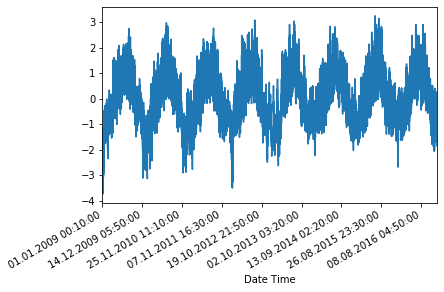

In [47]:
data.plot(subplots=True)

Maintenant, nous allons normaliser les données de test: en ML la qualité des données est essentielle pour obtenir des modèles prédictifs performants. Pour éviter de traiter des données erronées et améliorer la performance du modèle, il faut impérativement analyser les données, détecter les anomalies le plus tôt possible et déterminer les étapes de prétraitement et de nettoyage appropriées.

La normalisation, grosso modo, réduit les valeurs à un intervalle donné afin de les considérer toutes dans le même ordre de grandeur.

Une des fonctions de normalisation fréquente est la normalisation par le test Z : mettre les données à l’échelle en fonction de la moyenne et de l’écart type en divisant la différence entre les données et la moyenne par l’écart type

In [48]:
data = data.values
train_data_mean = data[:TRAIN_DATA_SIZE].mean()
train_data_std = data[:TRAIN_DATA_SIZE].std()

data = (data - train_data_mean) / train_data_std

Créeons maintenant nos différents sets de données d'apprentissage et de prédiction.
Mettons qu'à un instant t, nous allons utiliser les 20 dernières observations pour prédire la prochaine (t+1).

Utilisons notre fonction de tout à l'heure:

In [49]:
past = 20
target = 0

x_train, y_train = data_window(
    data,
    0,
    TRAIN_DATA_SIZE,
    past,
    target
    )
x_validation, y_validation = data_window(
    data,
    TRAIN_DATA_SIZE,
    None,
    past,
    target
    )


Nous avons donc maintenant nos fenêtres de données, ainsi que les valeurs à prédire; nous en avons pour chacun de nos set de données: un d'entraînement et un de validation.
Regardons un peu à quoi ça ressemble: les informations passées sont en bleu, et la prédiction est en rouge.

In [50]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def show_plot(plot_data, delta, title):
  labels = ['Historique', 'Vraie valeur', 'Valeur prédite']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/Users/elia/Kode/gdg/.tensorflow/lib/python3.7/site-packages/matplotlib/pyplot.py'>

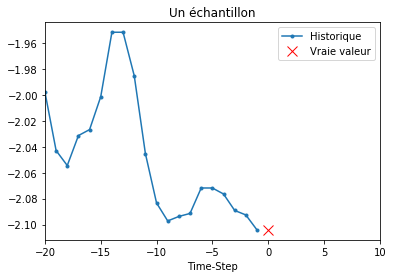

In [52]:
show_plot([x_train[0], y_train[0]], 0, 'Un échantillon')

On peut se rendre compte que la prédiction basée sur la simple moyenne n'est pas très précise. Voyons si avec un réseau de neurones récurrents on peut mieux faire.

In [53]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

training = tf.data.Dataset.from_tensor_slices((x_train, y_train))
training = training.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

validation = tf.data.Dataset.from_tensor_slices((x_validation, y_validation))
validation = validation.batch(BATCH_SIZE).repeat()


simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

simple_lstm_model.fit(
    training,
    epochs=10,
    steps_per_epoch=200,
    validation_data=validation,
    validation_steps=50
    )



Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 28ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0263 - val_loss: 0.0197
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0253 - val_loss: 0.0181
Epoch 10/10
200/200 [===========================

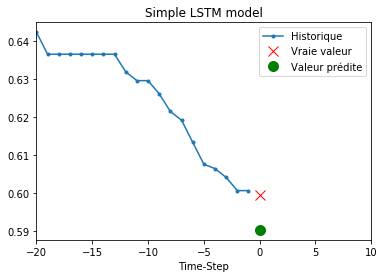

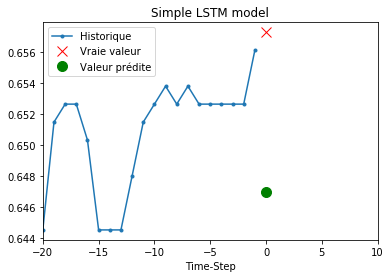

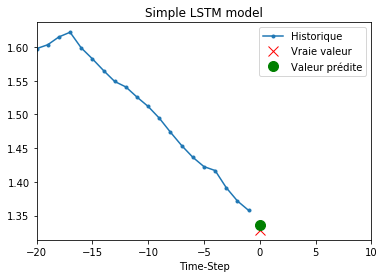

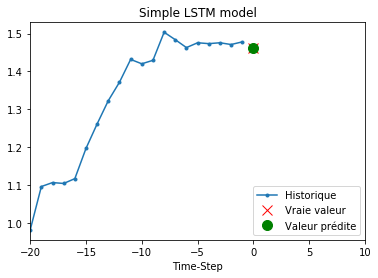

In [54]:
for x, y in validation.take(4):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

![True ML](https://imgs.xkcd.com/comics/machine_learning.png "True ML")